### Importing Libraries

In [ ]:
import librosa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score #21BAI1210

### Read dataset

In [5]:
df = pd.read_csv("esc50.csv")
audio_dir = "audio"

### Extract Features

In [6]:
data = []
labels = []
failed_files = []

for index, row in df.iterrows():
    filename = row['filename']
    label = row['category']
    filepath = os.path.join(audio_dir, filename)
    try:
        y, sr = librosa.load(filepath, sr=None, mono=True)

        threshold = 0.001
        rms_energy = np.sqrt(np.mean(y**2))

        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr).T, axis=0)
        features = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))
        data.append(features)
        labels.append(label)

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        failed_files.append(filename)

if not data:
    raise ValueError("No features were extracted. Check your audio files and paths.")

/home/yadu/anaconda3/envs/speech-and-nlp-lab/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


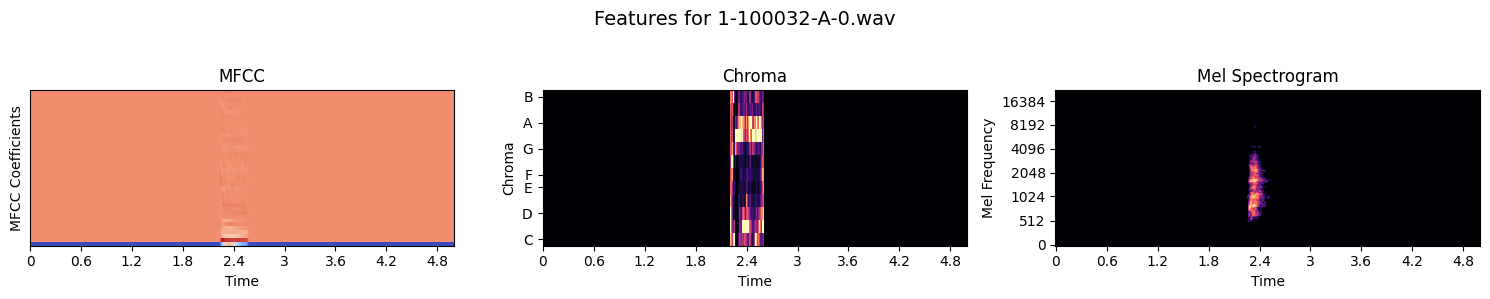

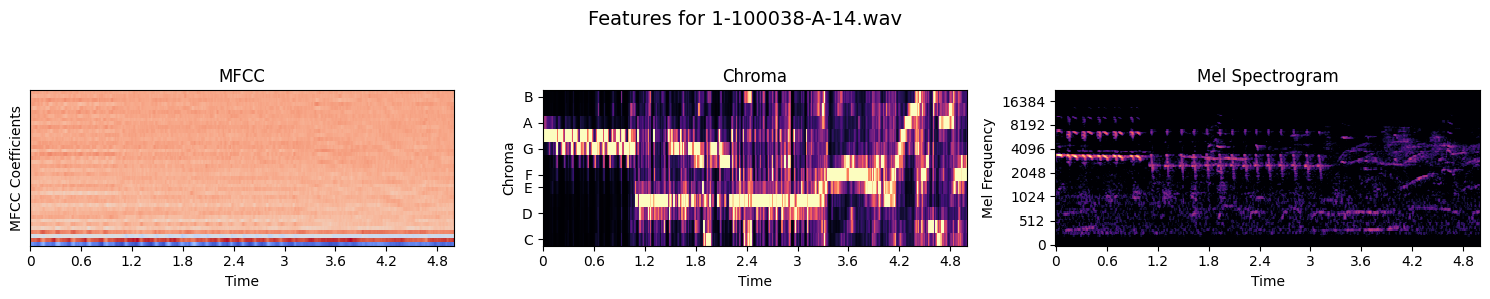

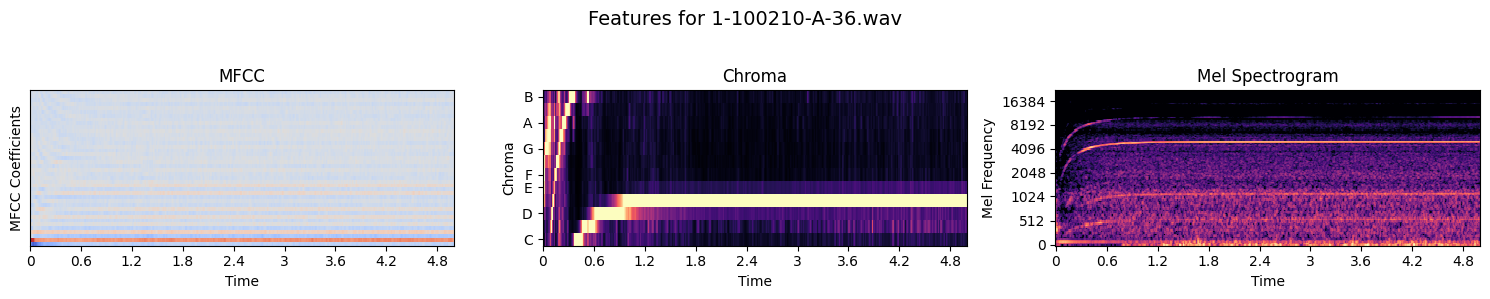

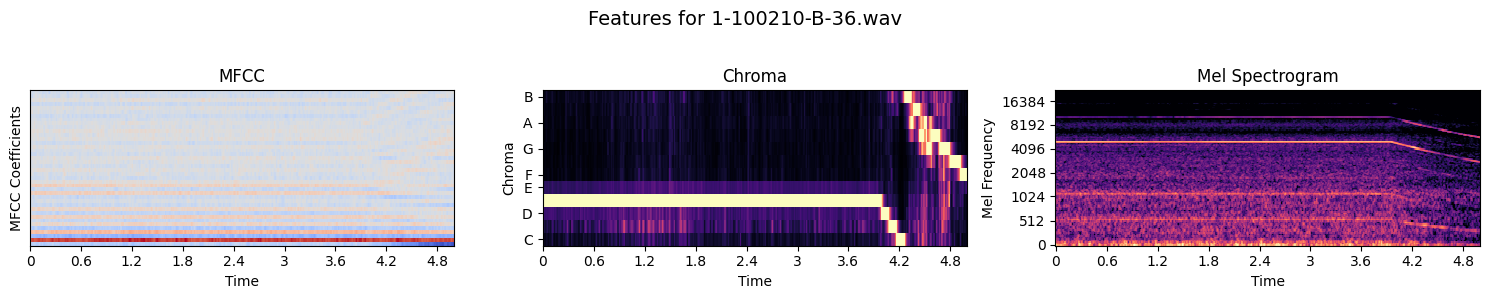

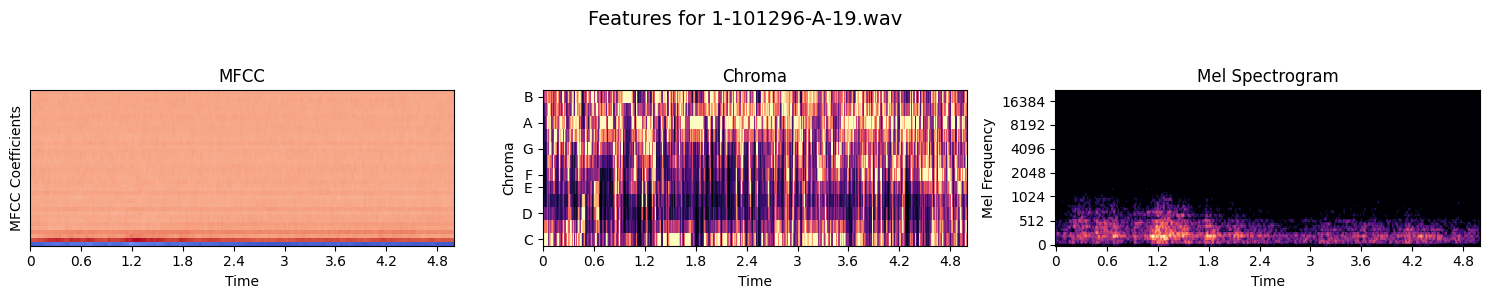

In [7]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os

# Number of samples to visualize
num_samples = 5

# Loop through the first five samples in the dataset
for i in range(num_samples):
    filename = df.loc[i, 'filename']
    filepath = os.path.join(audio_dir, filename)
    
    # Load the audio file
    y, sr = librosa.load(filepath, sr=None)

    # Create a single row of subplots for MFCC, Chroma, and Mel Spectrogram
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))

    # Plot MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    librosa.display.specshow(mfccs, x_axis='time', ax=axes[0], sr=sr)
    axes[0].set_title('MFCC')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('MFCC Coefficients')

    # Plot Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=axes[1], sr=sr)
    axes[1].set_title('Chroma')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Chroma')

    # Plot Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[2])
    axes[2].set_title('Mel Spectrogram')
    axes[2].set_xlabel('Time')
    axes[2].set_ylabel('Mel Frequency')

    # Display filename above the row of plots
    fig.suptitle(f"Features for {filename}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title
    plt.show()


### Setup and Train the Model

In [8]:

from tensorflow.keras.callbacks import EarlyStopping

# Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

# Fold-based splitting
test_fold = 3  # Change for cross-validation
train_data = df[df['fold'] != test_fold]
test_data = df[df['fold'] == test_fold]

X_train = np.array([data[i] for i in train_data.index])
y_train = np.array([y_encoded[i] for i in train_data.index])
X_test = np.array([data[i] for i in test_data.index])
y_test = np.array([y_encoded[i] for i in test_data.index])

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Keras Model
model = keras.Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=64,
                    validation_data=(X_test, y_test), )

/home/yadu/anaconda3/envs/speech-and-nlp-lab/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1731517972.040169   33737 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.0682 - loss: 3.8880 - val_accuracy: 0.1800 - val_loss: 3.5882
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2283 - loss: 3.1157 - val_accuracy: 0.2375 - val_loss: 3.1462
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3469 - loss: 2.5765 - val_accuracy: 0.2750 - val_loss: 2.9290
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4430 - loss: 2.1221 - val_accuracy: 0.3475 - val_loss: 2.7018
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4874 - loss: 1.8638 - val_accuracy: 0.3425 - val_loss: 2.7637
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5604 - loss: 1.6201 - val_accuracy: 0.3650 - val_loss: 2.7460
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5930 - loss: 1.4193 - val_accuracy: 0.3700 - val_loss: 2.9168
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6354 - loss: 1.2908 - val_accuracy: 0.3700 - val_loss

### Plot Metrics

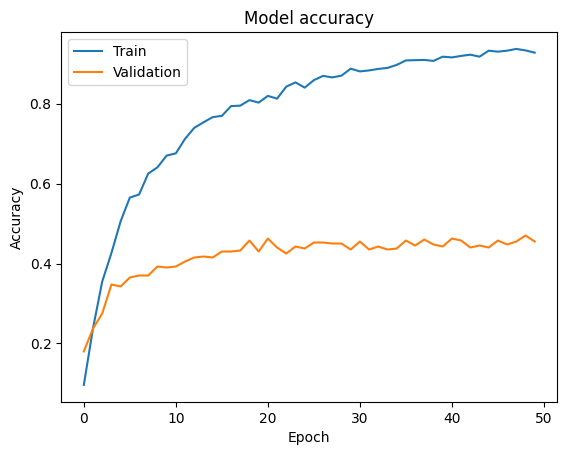

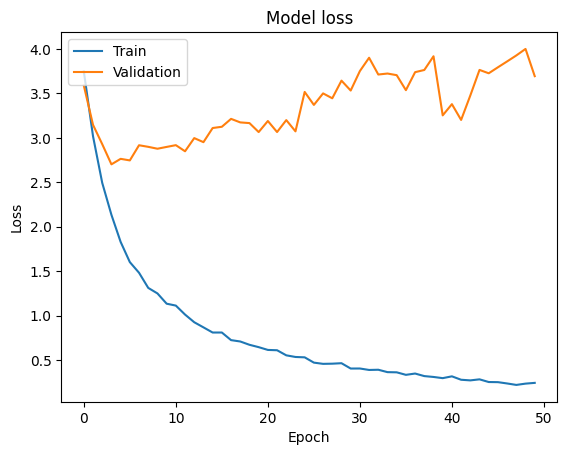

In [9]:
# Plotting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Make Predictions

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy (Fold 3): 0.455


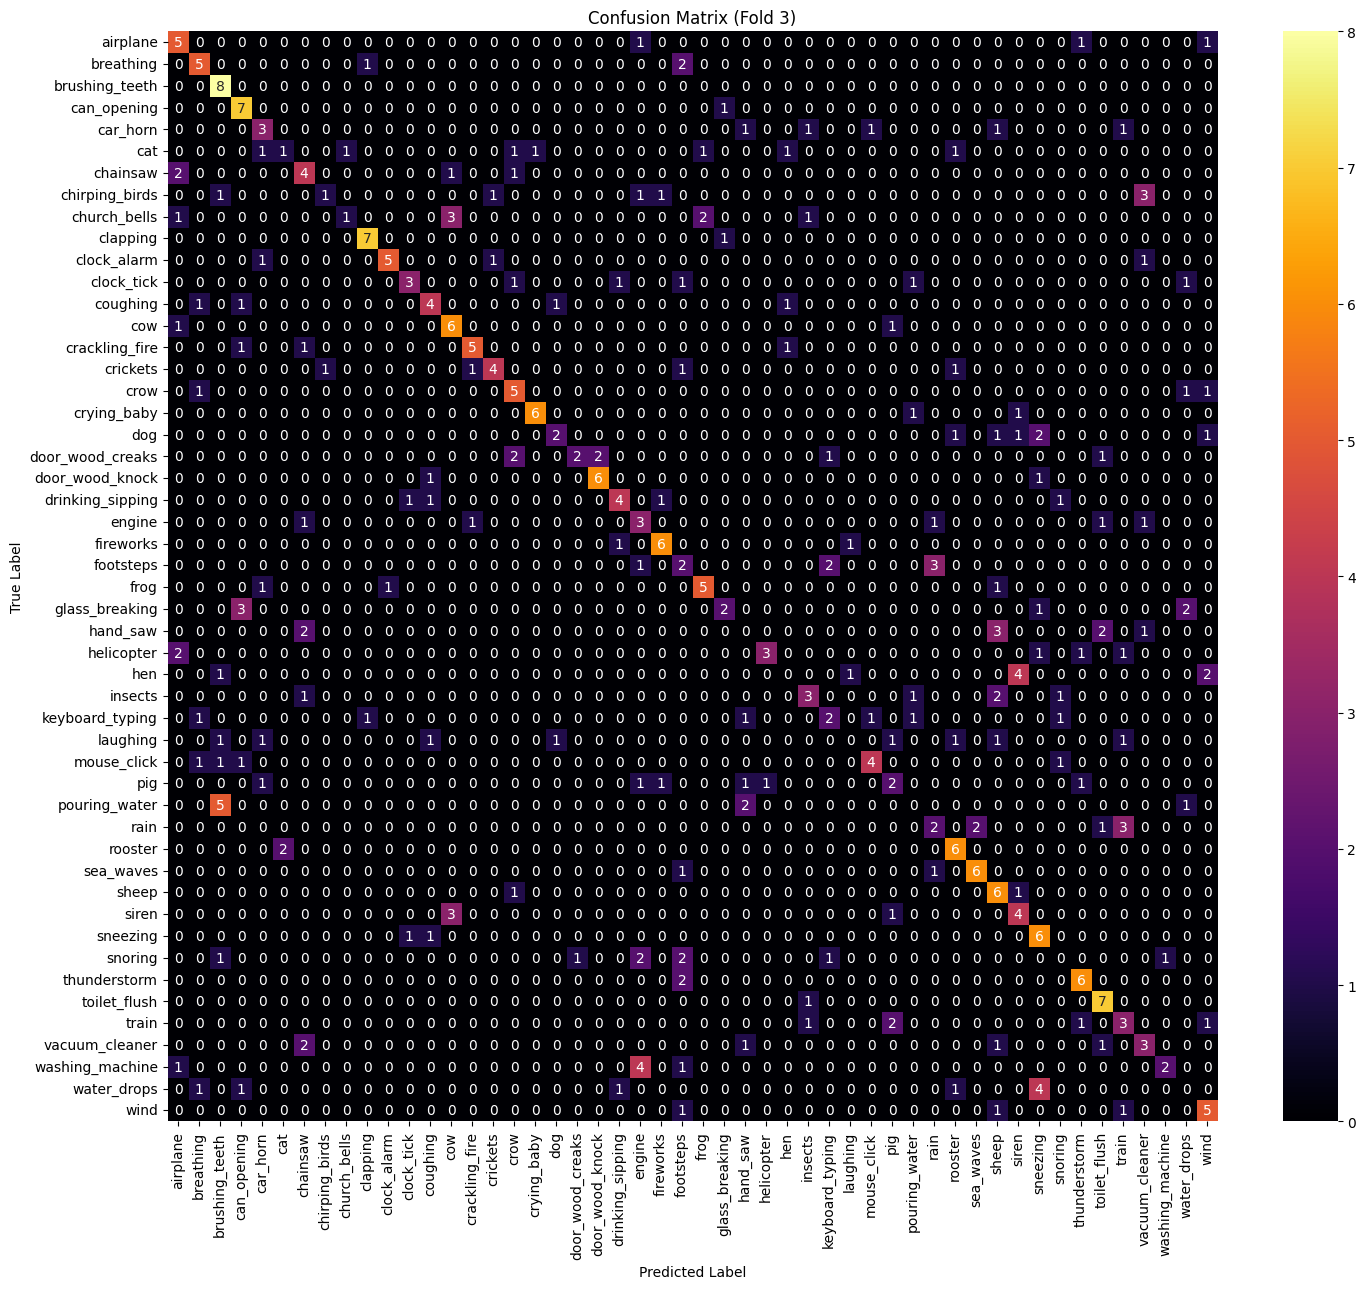

                  precision    recall  f1-score   support

        airplane       0.42      0.62      0.50         8
       breathing       0.50      0.62      0.56         8
  brushing_teeth       0.44      1.00      0.62         8
     can_opening       0.50      0.88      0.64         8
        car_horn       0.38      0.38      0.38         8
             cat       0.33      0.12      0.18         8
        chainsaw       0.36      0.50      0.42         8
  chirping_birds       0.50      0.12      0.20         8
    church_bells       0.50      0.12      0.20         8
        clapping       0.78      0.88      0.82         8
     clock_alarm       0.83      0.62      0.71         8
      clock_tick       0.60      0.38      0.46         8
        coughing       0.50      0.50      0.50         8
             cow       0.46      0.75      0.57         8
  crackling_fire       0.71      0.62      0.67         8
        crickets       0.67      0.50      0.57         8
            c

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Fold {test_fold}): {accuracy}")

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 13)) # Adjust size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="inferno", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix (Fold {test_fold})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred, target_names=le.classes_)) #21BAI1210